# Hyperparameter tuning

### Import of data

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # disable info log from tensorflow
import tensorflow as tf
import keras_tuner as kt

from modules.TrainOnOneSite import Trainer
from modules.Plotter import GeneralPlotter 
from modules.DatasetWrapper import Dataset
from modules.kerasGenerator import plot_model_info
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

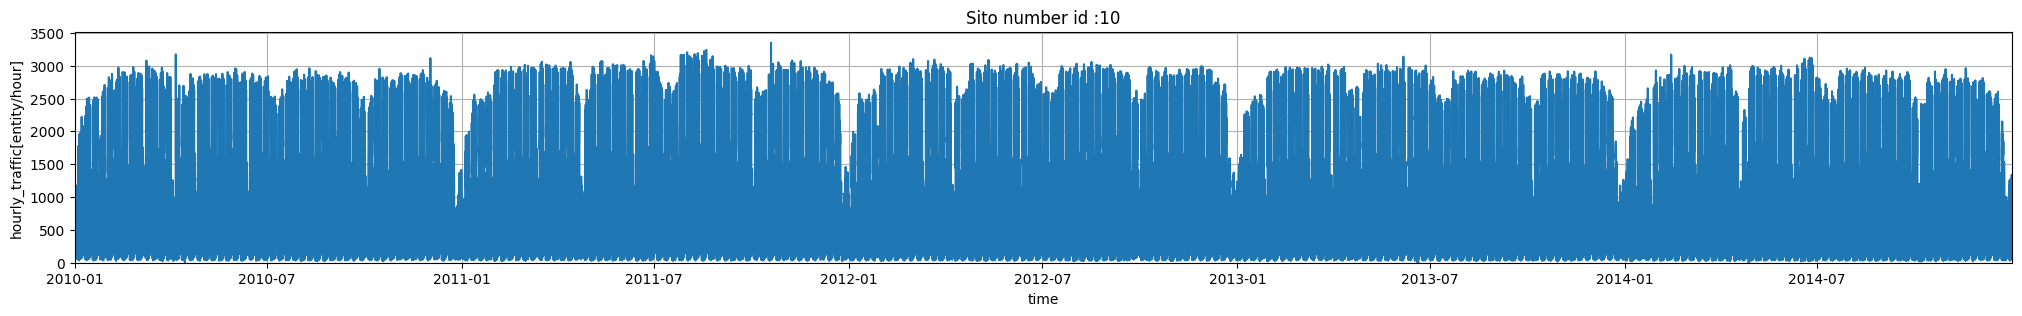

,mean,std,min,25%,50%,75%,max
hourly_traffic,0.548256,0.427252,0.000000,0.134444,0.472222,0.882778,1.861111
temperature_2m,0.833086,0.301616,0.117000,0.612000,0.774500,1.004500,2.019500
apparent_temperature,0.721823,0.344139,-0.049737,0.465404,0.656857,0.925835,2.071331
relative_humidity_2m,0.657317,0.197985,0.081371,0.516910,0.679468,0.820077,1.000000
precipitation,0.010049,0.049863,0.000000,0.000000,0.000000,0.000000,1.560000
wind_speed_10m,1.068027,0.514500,0.000000,0.686417,1.012845,1.399428,3.755674
cloud_cover,0.338667,0.311726,0.000000,0.030000,0.288000,0.558000,1.000000


Site type: SIGNALISED_4_WAY_INTERSECTION


In [2]:
Site_No = 10
data = Dataset()
_ = data.select_site(Site_No)

In [5]:
X_FEATURES = Trainer.OLD_X_FEATURES
X_WINDOWS  = Trainer.OLD_X_WINDOWS

print(F"input_len={X_WINDOWS}\nx_features={X_FEATURES}")
workspace = "Hyper_tuning"
train, valid, test = data.split_and_get_generators(X_col=X_FEATURES, input_size=X_WINDOWS)
trainer = Trainer(train, valid, test, workspace)

input_len=10
x_features=['hourly_traffic', 'hour_of_day(sin)', 'hour_of_day(cos)', 'day_of_week(sin)', 'day_of_week(cos)', 'holiday', 'temperature_2m', 'apparent_temperature', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'cloud_cover']


### HyperModel Class

In [4]:
class LSTMHyperModel(kt.HyperModel):
    def __init__(self):
        super(LSTMHyperModel, self).__init__()
        pass

    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(data.input_width, len(data.X_col))))
        
        # Tuning del numero di strati e units per LSTM 
        num_lstm_layers = hp.Int('num_lstm_layers', 1, 2)
        for i in range(num_lstm_layers):
            model.add(
                tf.keras.layers.LSTM(
                    units=hp.Int(f'lstm_units_{i}', min_value=64, max_value=512, step=64),
                    return_sequences = i < num_lstm_layers - 1
                ),
            )
        if num_lstm_layers == 2:
            model.add(
                tf.keras.layers.Dense(hp.Choice('dense_units', [data.input_width*len(data.X_col), 64, 128]))
            )
        
        # Tuning units e activation function
        model.add(
            tf.keras.layers.Dense(
                data.label_width,
                activation=hp.Choice('output_dense_activation', ['linear', 'relu', 'tanh'])
            )
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='mean_squared_error',
            metrics=['mean_absolute_error']
        )
        return model

### Tuning

In [5]:
tuner = kt.Hyperband(
    LSTMHyperModel(),
    objective='val_mean_absolute_error',
    max_epochs=15,
    directory='temp/hypertuning',
    project_name='LSTM_Tuning'
)

tuner.search(
    train,
    validation_data=valid,
    epochs=8
)

print("\n\n--------")
tuner.results_summary()

Trial 30 Complete [00h 13m 09s]
val_mean_absolute_error: 0.06239042058587074

Best val_mean_absolute_error So Far: 0.030459092929959297
Total elapsed time: 02h 43m 45s


--------
Results summary
Results in hypertuning/LSTM_Tuning
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 0024 summary
Hyperparameters:
num_lstm_layers: 2
lstm_units_0: 256
output_dense_activation: linear
learning_rate: 0.001
lstm_units_1: 256
dense_units: 64
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.030459092929959297

Trial 0017 summary
Hyperparameters:
num_lstm_layers: 1
lstm_units_0: 320
output_dense_activation: relu
learning_rate: 0.001
lstm_units_1: 512
dense_units: 128
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.030652057379484177

Trial 0016 summary
Hyperparameters:
num_lstm_layers: 1
lstm_units_0: 256
output_dense_activation: relu
learning_rate: 0.01
l

### Evaluation dei 3 migliori modelli sul test set

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "tuned_LSTM_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 256)        │       275,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,451,845 (9.35 MB)

 Trainable params: 817,281 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,634,564 (6.24 MB)

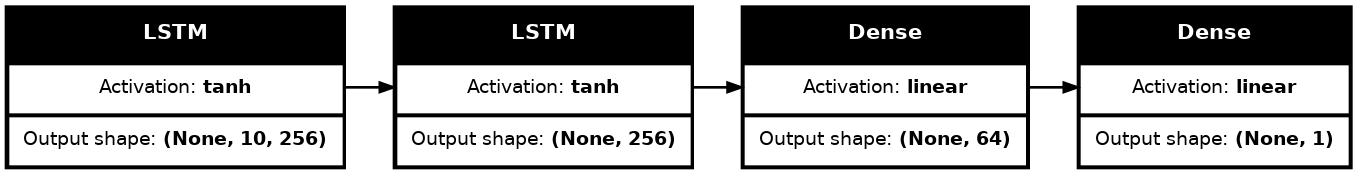

Learning rate: 0.001

Training Score:
821/821 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step
mean_squared_error: 0.0020(0.0447) - mean_absolute_error: 0.0302
DeNorm_mean_squared_error: 6560.2803(80.9956) - DeNorm_mean_absolute_error: 54.3954


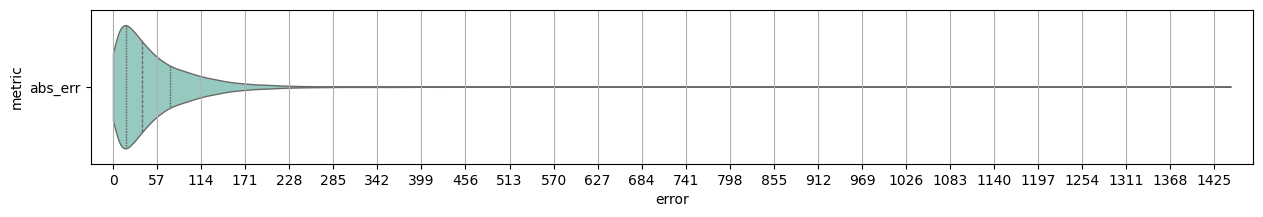

,mean,std,min,25%,50%,75%,max
error,54.395423,60.01296,0.000048,16.787616,37.297057,73.562566,1446.217497



Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step
mean_squared_error: 0.0022(0.0469) - mean_absolute_error: 0.0304
DeNorm_mean_squared_error: 7277.6382(85.3091) - DeNorm_mean_absolute_error: 54.7480


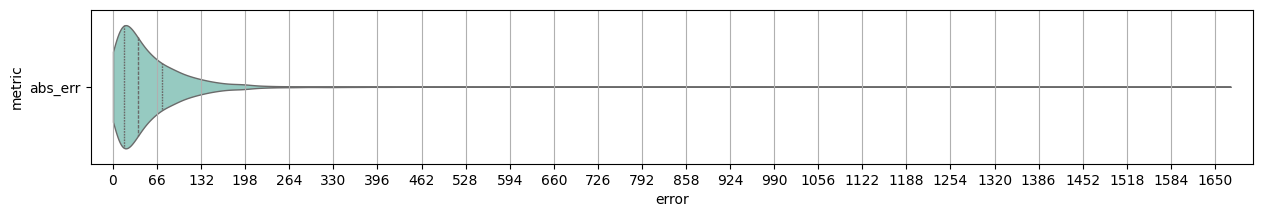

,mean,std,min,25%,50%,75%,max
error,54.748027,65.4277,0.022784,16.856651,36.833177,73.15771,1673.773849



Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step
mean_squared_error: 0.0027(0.0520) - mean_absolute_error: 0.0352
DeNorm_mean_squared_error: 8862.9854(94.1434) - DeNorm_mean_absolute_error: 63.3033


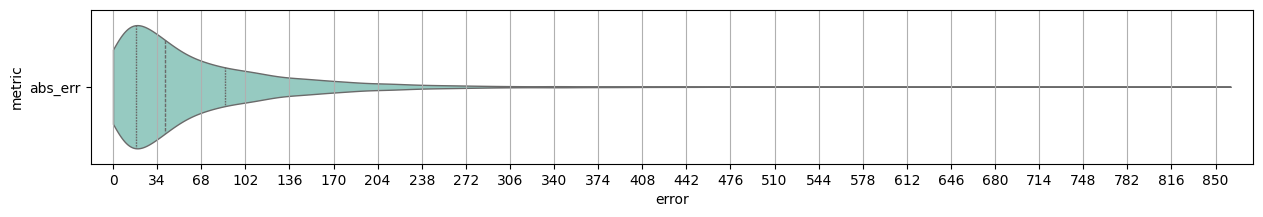

,mean,std,min,25%,50%,75%,max
error,63.303315,69.686682,0.001548,17.412388,40.167943,86.270608,861.752912


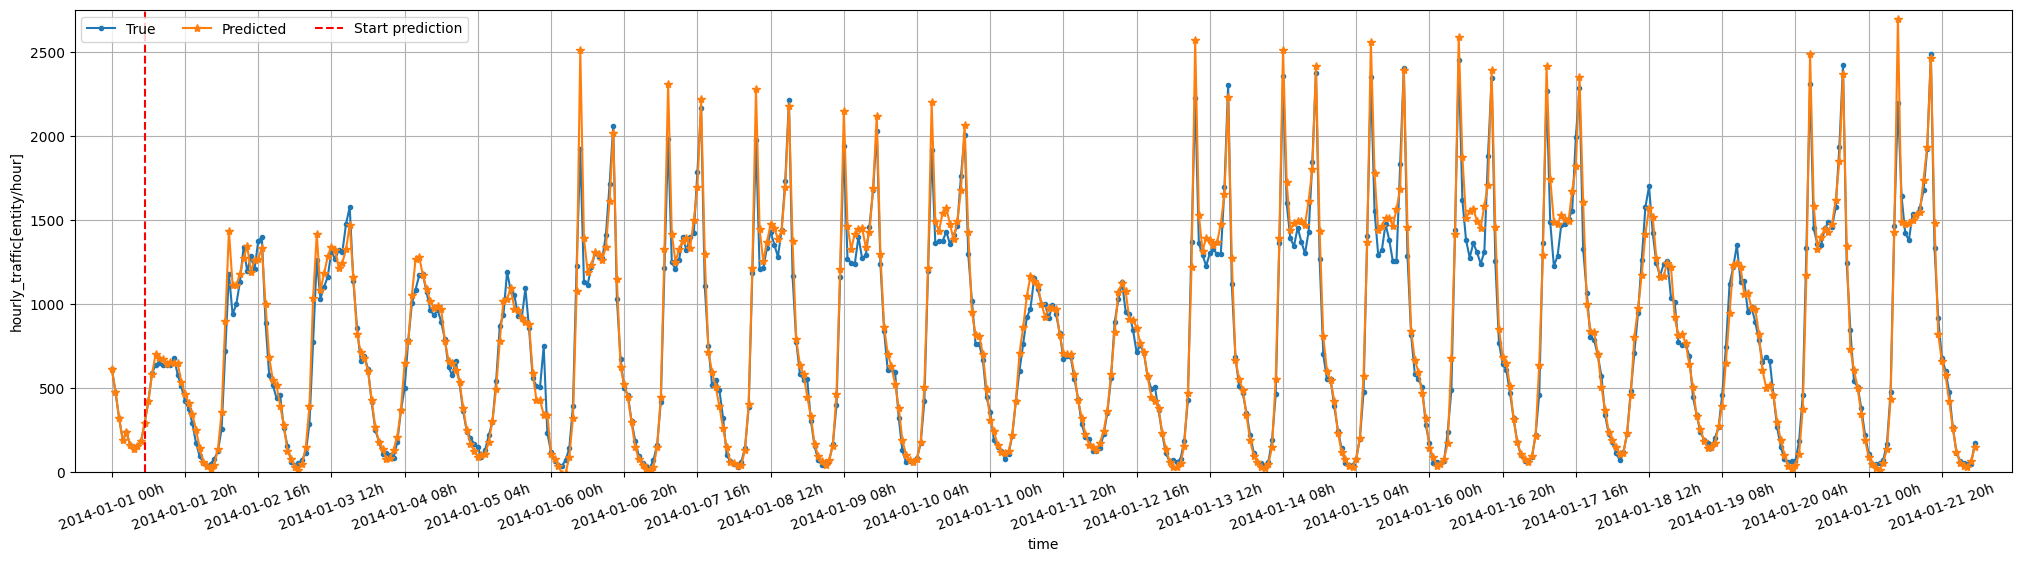

--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "tuned_LSTM_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 320)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,279,685 (4.88 MB)

 Trainable params: 426,561 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 853,124 (3.25 MB)

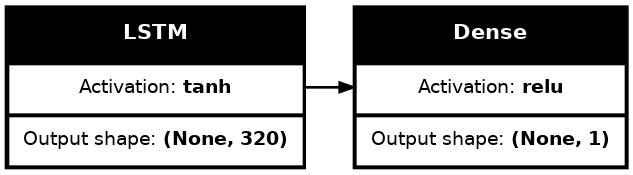

Learning rate: 0.001

Training Score:
821/821 ━━━━━━━━━━━━━━━━━━━━ 58s 70ms/step
mean_squared_error: 0.0021(0.0458) - mean_absolute_error: 0.0308
DeNorm_mean_squared_error: 6845.5342(82.7377) - DeNorm_mean_absolute_error: 55.3799


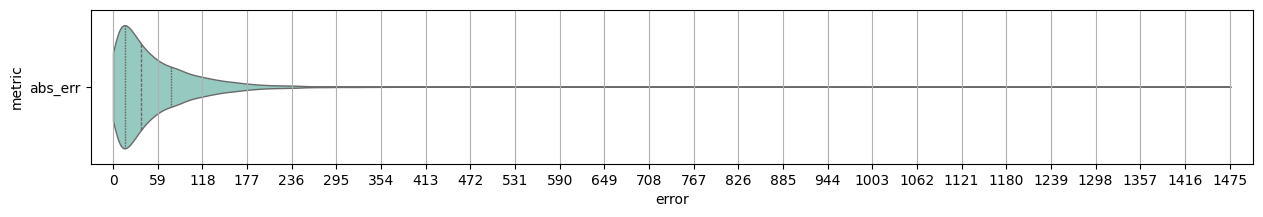

,mean,std,min,25%,50%,75%,max
error,55.379936,61.471469,0.0,16.355038,36.989937,76.223185,1476.647695



Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step
mean_squared_error: 0.0023(0.0480) - mean_absolute_error: 0.0306
DeNorm_mean_squared_error: 7474.0786(86.4528) - DeNorm_mean_absolute_error: 55.0698


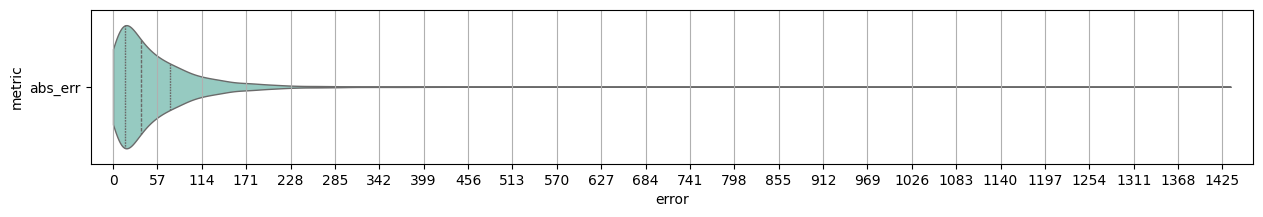

,mean,std,min,25%,50%,75%,max
error,55.069844,66.647586,0.0,15.536266,36.171915,73.730774,1435.788706



Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step
mean_squared_error: 0.0028(0.0529) - mean_absolute_error: 0.0355
DeNorm_mean_squared_error: 9049.4385(95.1285) - DeNorm_mean_absolute_error: 63.9693


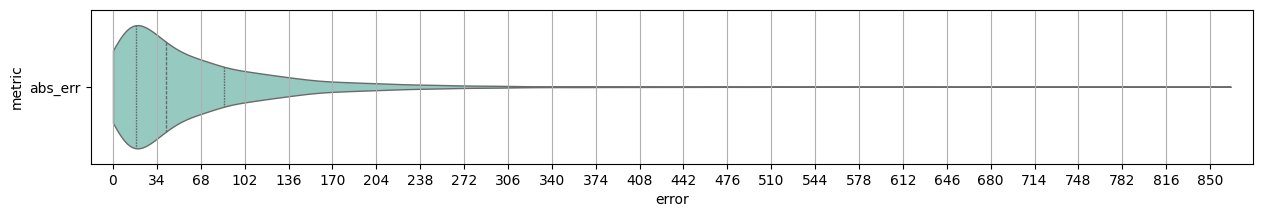

,mean,std,min,25%,50%,75%,max
error,63.969317,70.412605,0.009251,17.872362,40.783733,85.873062,866.072126


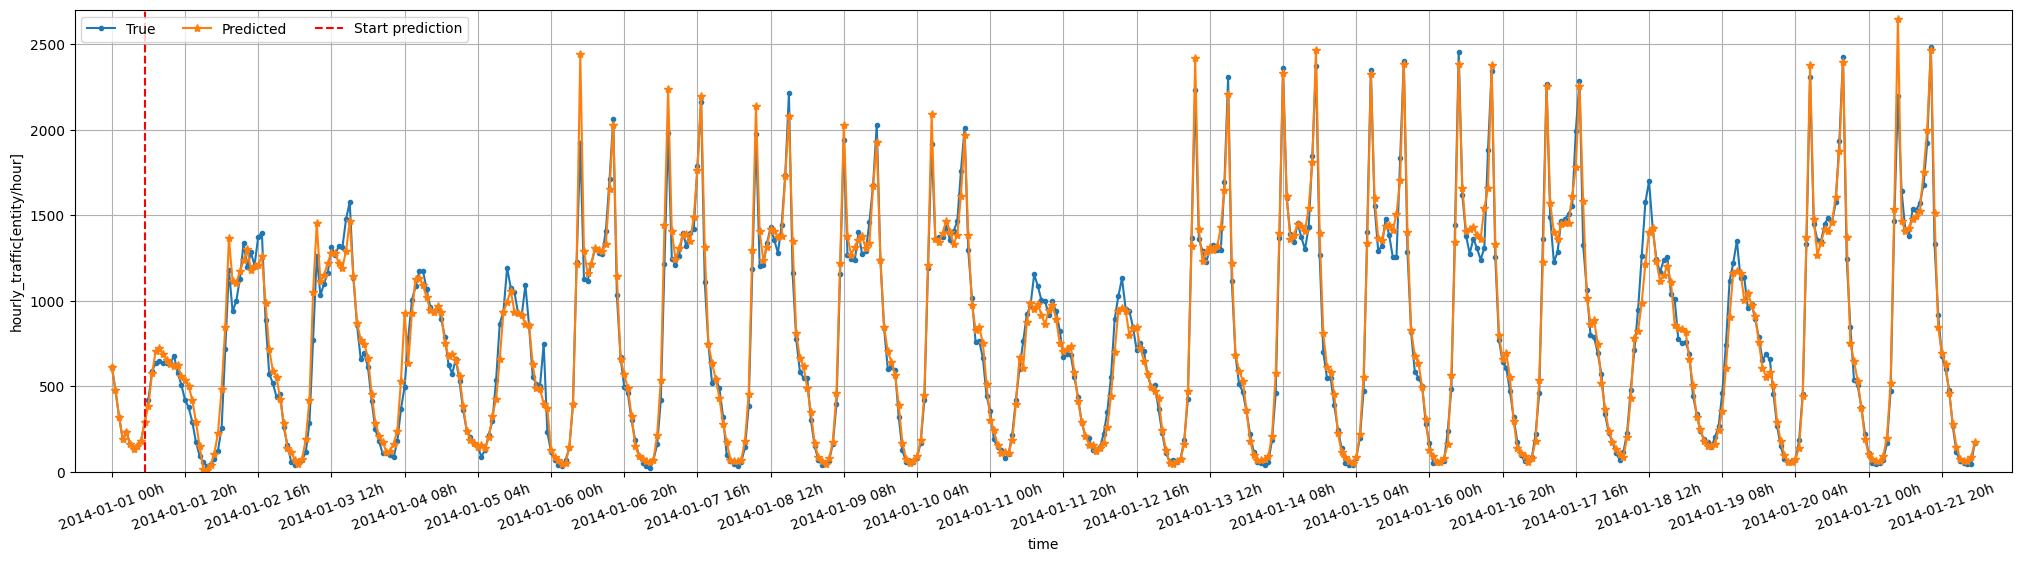

--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "tuned_LSTM_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       275,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 827,141 (3.16 MB)

 Trainable params: 275,713 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 551,428 (2.10 MB)

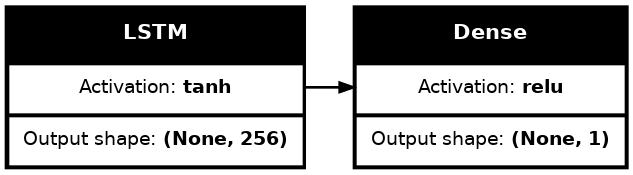

Learning rate: 0.01

Training Score:
821/821 ━━━━━━━━━━━━━━━━━━━━ 85s 104ms/step
mean_squared_error: 0.0020(0.0447) - mean_absolute_error: 0.0300
DeNorm_mean_squared_error: 6526.4800(80.7866) - DeNorm_mean_absolute_error: 54.0091


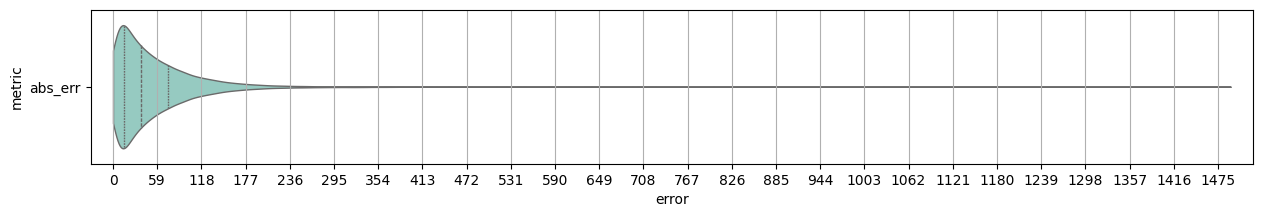

,mean,std,min,25%,50%,75%,max
error,54.009127,60.080207,0.002001,15.242704,36.825972,74.016272,1492.189916



Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step
mean_squared_error: 0.0024(0.0490) - mean_absolute_error: 0.0321
DeNorm_mean_squared_error: 7662.5034(87.5357) - DeNorm_mean_absolute_error: 57.8402


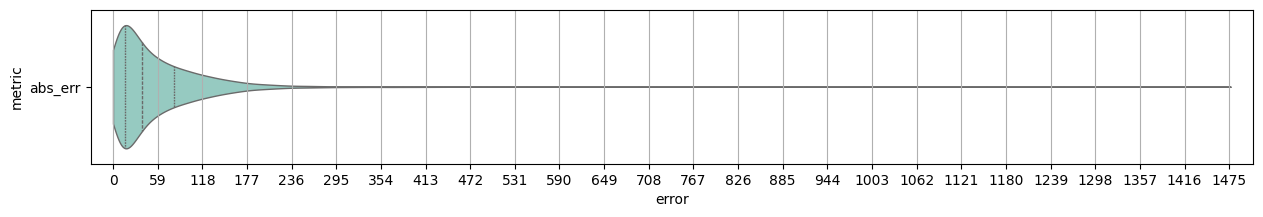

,mean,std,min,25%,50%,75%,max
error,57.840243,65.707729,0.0,16.127872,37.891456,80.268472,1477.162209



Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step
mean_squared_error: 0.0030(0.0548) - mean_absolute_error: 0.0374
DeNorm_mean_squared_error: 9590.6826(97.9320) - DeNorm_mean_absolute_error: 67.3774


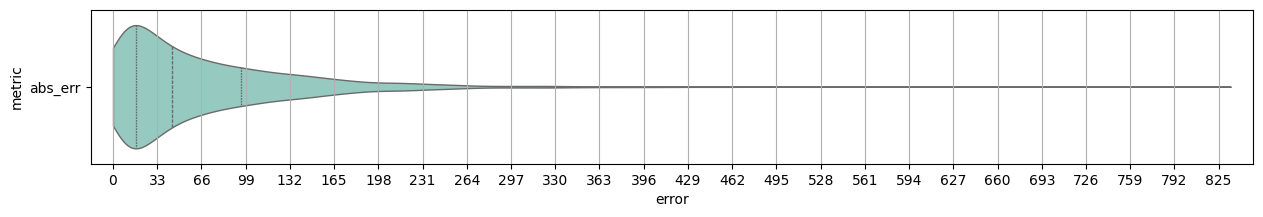

,mean,std,min,25%,50%,75%,max
error,67.377417,71.074234,0.013737,17.414021,43.910429,95.857689,834.045478


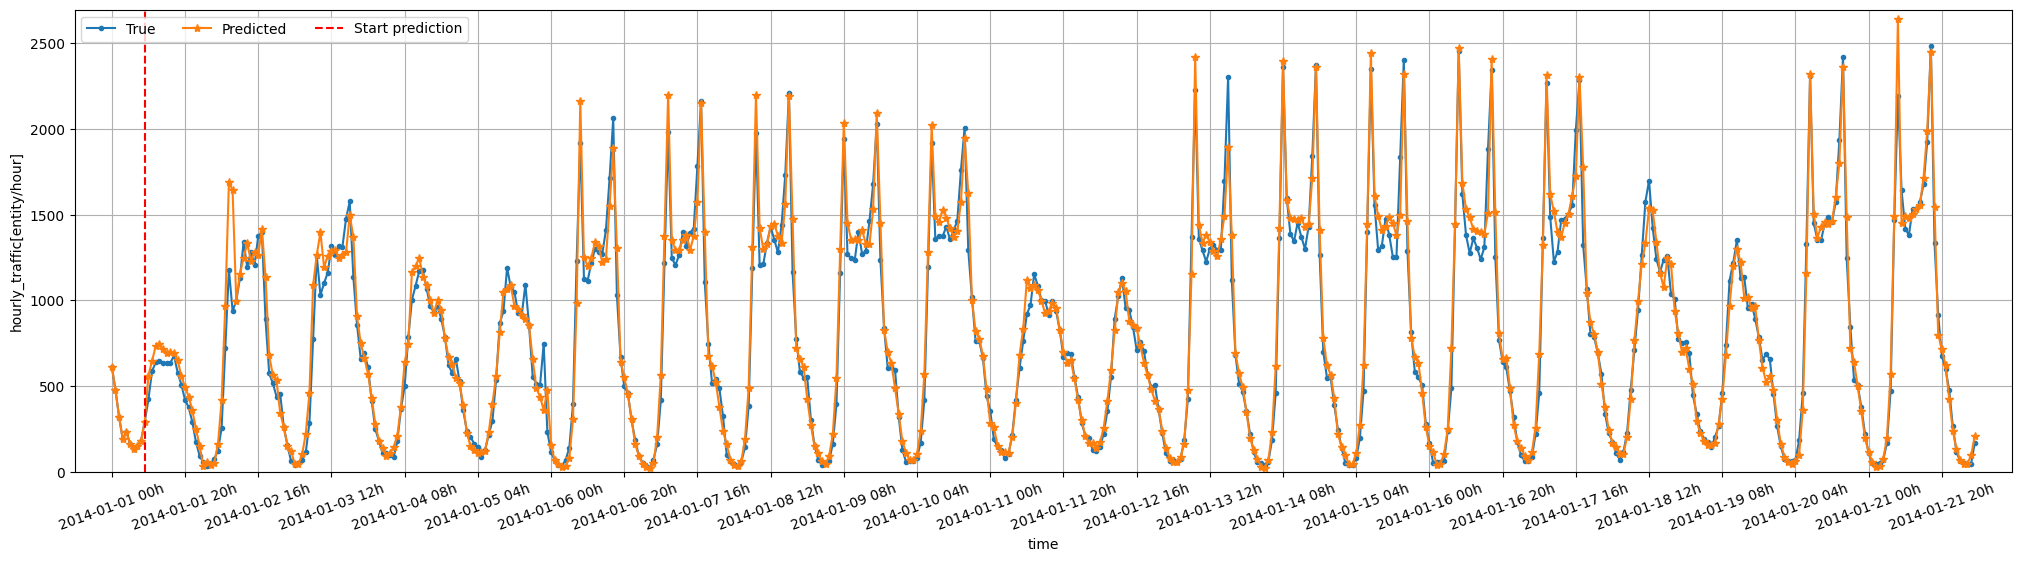

--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---


In [14]:
i = 0
for model in tuner.get_best_models(num_models=3):
    model.name = f"tuned_LSTM_{i}"
    print(f"\033[1m{i+1} modello\033[0m:")
    
    plot_model_info(model, f"{trainer.Workspace}/{model.name}/")
    print("\033[1mLearning rate\033[0m:", model.optimizer.learning_rate.numpy())
    
    trainer.evaluate_metrics_on_dataset(model)
    model.save(f"./models/Tuned_LSTM_{i+1}.keras")
    print("--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---")
    i+=1
del i
# models = ["models/tuned_LSTM_1.keras", "models/tuned_LSTM_2.keras", "models/tuned_LSTM_3.keras"]
# names  = ["tuned_LSTM_1", "tuned_LSTM_2", "tuned_LSTM_3"]
# learning_rate = [0.001,0.001,0.01]
# 
# 
# for model_path, model_name, model_lr in zip(models, names, learning_rate):
#     model = tf.keras.models.load_model(model_path)
#     model.name = model_name
# 
#     plot_model_info(model, f"{trainer.Workspace}/{model_name}/")
#     print("\033[1mLearning rate\033[0m:", model_lr)
#     
#     trainer.evaluate_metrics_on_dataset(model)
#     print("--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---")